In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt 
import torch 

import warnings
warnings.filterwarnings("ignore")

In [2]:
idxc = pd.read_csv('../task3/clean_data/clean_idxc.csv')
y_pred = pd.read_csv('../task3/clean_data/clean_pred.csv')
y_true = pd.read_csv('../task3/clean_data/clean_true.csv')
rf = pd.read_csv('../task3/clean_data/clean_ortho_rf.csv')
factor_ret = pd.read_csv('../task3/clean_data/clean_factor_ret.csv')

In [3]:
c1 = 0.0012+0.00015
c2 = 0.001

In [4]:
# 把stock_return调整为前后两天的价格比，并加入现金部分，记为stock_code=-1
def add_cash(y_true):
    date_idx = np.sort(np.array(list(set(y_true['trade_date']))))
    y_true['stock_return']+=1
    y_true = y_true.rename(columns={'stock_return':'y_t'})
    for date in date_idx:
        cash = pd.DataFrame({'trade_date':[date],'stock_code':[-1],'y_t':[1]})
        y_true = pd.concat([y_true,cash],axis=0,ignore_index=True)
    y_true = y_true.sort_values(['trade_date','stock_code'])
    y_true.index = range(len(y_true))
    return y_true

In [5]:
# 计算交易折扣因子
def get_mu_cash(df,c1,c2):
    
    def relu(x):
        if x>=0:
            return x
        else:
            return 0
    
    def function_mu(df,c1,c2,mu):
        sigma = 0
        for i in range(1,len(df)):
            sigma+=relu(df['wt_prime'].iloc[i]-mu*df['w_t'].iloc[i])
        numerator = 1+c1-c1*df['wt_prime'].iloc[0]-(2*c1+c2)*sigma
        denominator = 1+c1-c1*df['w_t'].iloc[0]
        return numerator/denominator

    
    mu_list=[]
    eps = 1e-15
    delta = 1
    mu = 1
    mu_list.append(mu)
    while delta>eps:
        mu = function_mu(df,c1,c2,mu)
        mu_list.append(mu)
        delta = abs(mu_list[-1]-mu_list[-2])
    
    return mu

In [6]:
# step函数，主要功能为计算每一步的回报
# y_true，w_before,w_after表都要包含现金部分，即stock_code=-1那一列
# w_before为前一天的持仓权重，w_after为当天调整仓位后的持仓权重,都以stock_code为index
def step_cash(trade_date,y_true,w_before,w_after):
    date_yt = y_true[y_true['trade_date']==trade_date].set_index('stock_code')['y_t']
    w_before = w_before.rename('w_t-1')
    w_after = w_after.rename('w_t')
    df = pd.concat([date_yt,w_before,w_after],axis=1,join='outer')
    df = df.fillna(0)
    df['wt_prime']=(df['y_t']*df['w_t-1'])/((df['y_t']*df['w_t-1']).sum())
    mu = get_mu_cash(df,c1,c2)
    reward = np.log(mu)+np.log((df['y_t']*df['w_t-1']).sum())
    next_trade_date = trade_date+1
    
    return next_trade_date,reward

In [7]:
def get_average_policy(n,y_pred,y_true):
    average_policy = pd.DataFrame()
    date_idx = np.sort(np.array(list(set(y_true['trade_date']))))
    for date in date_idx:
        # 首先保证y_pred表中的候选stock_code在y_true表中都有
        set1 = set(y_true[y_true['trade_date']==date]['stock_code'])
        set2 = set(y_pred[y_pred['trade_date']==date]['stock_code'])
        candidate_stock_code = list(set1 & set2)
        # 排序得到score在前n名的股票的stock_code
        temp = y_pred[y_pred['trade_date']==date]
        temp = temp[temp['stock_code']==candidate_stock_code]
        temp = temp.sort_values('score',ascending=False).iloc[0:n]['stock_code']
        first_n_stock_code = np.sort(np.array(list(set(temp))))
        temp2 = {
                "trade_date":list((np.ones(n)*date).astype(int)),
                "stock_code":first_n_stock_code,
                "weight":list((np.ones(n)/n).astype(float))
                }
        temp2 = pd.DataFrame(temp2)
        average_policy = pd.concat([average_policy,temp2],axis=0)
    return average_policy

In [8]:
# 对持仓权重表进行结构化（对不持仓的股票的weight补零，并添加现金部分）
def struct(df_weight,y_true):
    date_idx = np.sort(np.array(list(set(df_weight['trade_date']))))
    new_df_weight = pd.DataFrame()
    for date in date_idx:
        temp = df_weight[df_weight['trade_date']==date].set_index('stock_code')
        temp2 = y_true[y_true['trade_date']==date].set_index('stock_code')
        # 对不持仓的股票的weight补零
        temp3 = pd.concat([temp,temp2],axis=1,join='outer').iloc[:,:2].fillna(0)
        temp3['trade_date'] = date
        temp3 = temp3.reset_index()
        # 添加现金项
        temp3.loc[0,'weight'] = 1-temp3[temp3['stock_code']!=-1]['weight'].sum()
        new_df_weight = pd.concat([new_df_weight,temp3],axis=0)
    return new_df_weight

In [9]:
# 计算df_weight1相比df_weight2的超额收益
# 其中df_weight1和df_weight2都必须为结构化后的表
def excess_return(df_weight1,df_weight2,y_true):
    rlist = []
    date_idx = np.sort(np.array(list(set(df_weight1['trade_date']) & set(df_weight2['trade_date']))))
    date_idx = date_idx[1:]
    for date in date_idx:
        w1_before = df_weight1[df_weight1['trade_date']==date-1].set_index('stock_code')['weight']
        w1_after = df_weight1[df_weight1['trade_date']==date].set_index('stock_code')['weight']
        _,r1 = step_cash(date,y_true,w1_before,w1_after)
        w2_before = df_weight2[df_weight2['trade_date']==date-1].set_index('stock_code')['weight']
        w2_after = df_weight2[df_weight2['trade_date']==date].set_index('stock_code')['weight']
        _,r2 = step_cash(date,y_true,w2_before,w2_after)
        rlist.append(r1-r2)
    return rlist

In [10]:
# 计算日均超额收益和年化超额收益
def ex_ret_mean_annul(ex_ret):
    ex_ret_mean = np.array(ex_ret).mean()
    ex_ret_annul = np.power((1+ex_ret_mean),252)-1
    return ex_ret_mean,ex_ret_annul

In [11]:
def test_average_policy(nlist,y_pred,y_true,idxc):
    test_rlist,test_rmean,test_rannul= [],[],[]
    for n in nlist:
        average_policy = get_average_policy(n,y_pred,y_true)
        df_weight1 = struct(average_policy,y_true)
        df_weight2 = struct(idxc,y_true)
        ex_ret= excess_return(df_weight1,df_weight2,y_true)
        ex_ret_mean,ex_ret_annul = ex_ret_mean_annul(ex_ret)
        test_rlist.append(ex_ret)
        test_rmean.append(ex_ret_mean)
        test_rannul.append(ex_ret_annul)
    return test_rlist,test_rmean,test_rannul

In [12]:
y_true = add_cash(y_true)

In [17]:
# 测试单个baseline的超额收益
policy = get_average_policy(1200,y_pred,y_true)
policy = struct(policy,y_true)
idxc = struct(idxc,y_true)

n=1200时,99天的日均超额收益:0.0001 	 年化超额收益:0.0301


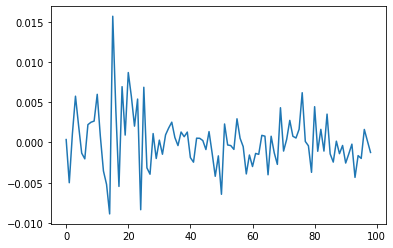

In [18]:
rlist = excess_return(policy,idxc,y_true)
rlist = rlist[-99:]
rmean,rannul = ex_ret_mean_annul(rlist)
plt.plot(rlist)
print("n=%d时,%d天的日均超额收益:%.4f \t 年化超额收益:%.4f" % (1200,len(rlist),rmean,rannul))

In [14]:
# 测试n取不同值时，baseline的超额收益
nlist = [50,100,200,500,800,1000,1200]
test_rlist,test_rmean,test_rannul = test_average_policy(nlist,y_pred,y_true,idxc)
for i in range(len(nlist)):
    plt.title('excess return(every trade day)')
    plt.plot(test_rlist[i])
    plt.show()
    print("n=%d时,%d天的日均超额收益:%.4f \t 年化超额收益:%.4f" % (nlist[i],len(test_rlist[i]),test_rmean[i],test_rannul[i]))

在按score排名，均分权重的策略下添加其他指标构造新的策略

In [44]:
def rolling_momentum(y_true,window):
    date_idx = np.sort(np.array(list(set(y_true['trade_date']))))
    code_idx = np.sort(np.array(list(set(y_true['stock_code']))))
    start_date = date_idx[0]+window
    date_idx = date_idx[window:]
    df_momentum = y_true.copy()
    df_momentum.drop('y_t',axis=1,inplace=True)
    df_momentum['m_score']=1
    df_momentum.drop(index = df_momentum[df_momentum['trade_date']<start_date].index,inplace=True)
    for date in date_idx:
        temp = y_true[(y_true['trade_date']>=date-window) & (y_true['trade_date']<date)]
        for code in code_idx:
            temp2 = temp[temp['stock_code']==code]
            m_score = temp2['y_t'].prod()
#             if len(temp2[temp2['y_t']<1]['y_t'])>0:
#                 m_score = temp2[temp2['y_t']<1]['y_t'].prod()
#             else:
#                 m_score = 1
            df_momentum.loc[df_momentum[(df_momentum['trade_date']==date)&(df_momentum['stock_code']==code)].index,'m_score']=m_score
    return df_momentum

In [46]:
m_score = rolling_momentum(y_true,window=10)

In [47]:
def rolling_var(y_true,window):
    eps = 1e-10
    date_idx = np.sort(np.array(list(set(y_true['trade_date']))))
    code_idx = np.sort(np.array(list(set(y_true['stock_code']))))
    start_date = date_idx[0]+window
    date_idx = date_idx[window:]
    df_var = y_true.copy()
    df_var.drop('y_t',axis=1,inplace=True)
    df_var['var_score']=0
    df_var.drop(index = df_var[df_var['trade_date']<start_date].index,inplace=True)
    for date in date_idx:
        temp = y_true[(y_true['trade_date']>=date-window) & (y_true['trade_date']<date)]
        for code in code_idx:
            temp2 = temp[temp['stock_code']==code]
            var_score = 1/(temp2['y_t'].std()+eps)
            df_var.loc[df_var[(df_var['trade_date']==date)&(df_var['stock_code']==code)].index,'var_score']=var_score
    return df_var

In [48]:
def get_policy2(n,y_pred,y_true,m_score):
    policy = pd.DataFrame()
    date_idx = np.sort(np.array(list(set(m_score['trade_date']))))
    for date in date_idx:
        set1 = set(y_true[y_true['trade_date']==date]['stock_code'])
        set2 = set(y_pred[y_pred['trade_date']==date]['stock_code'])
        candidate_stock_code = list(set1 & set2)
        temp = y_pred[y_pred['trade_date']==date].set_index('stock_code')['score']
        m_temp = m_score[m_score['trade_date']==date].set_index('stock_code')['m_score']
        temp2 = pd.concat([temp,m_temp],axis=1,join='inner')
        temp2 = temp2.sort_values(['score'],ascending=False).iloc[0:n]
        weight = temp2['m_score']*(np.ones(n)/n)
        weight = weight/weight.sum()
        temp3 = {
                "trade_date":list((np.ones(n)*date).astype(int)),
                "stock_code":list(temp2.index),
                "weight":list(weight)
                }
        temp3 = pd.DataFrame(temp3)
        policy = pd.concat([policy,temp3],axis=0)
    return policy

In [56]:
def get_policy3(n,y_pred,y_true,var_score):
    policy = pd.DataFrame()
    date_idx = np.sort(np.array(list(set(m_score['trade_date']))))
    for date in date_idx:
        set1 = set(y_true[y_true['trade_date']==date]['stock_code'])
        set2 = set(y_pred[y_pred['trade_date']==date]['stock_code'])
        candidate_stock_code = list(set1 & set2)
        temp = y_pred[y_pred['trade_date']==date].set_index('stock_code')['score']
        var_temp = var_score[var_score['trade_date']==date].set_index('stock_code')['var_score']
        temp2 = pd.concat([temp,var_temp],axis=1,join='inner')
        temp2 = temp2.sort_values(['score'],ascending=False).iloc[0:n]
        weight = temp2['var_score']*(np.ones(n)/n)
        weight = weight/weight.sum()
        temp3 = {
                "trade_date":list((np.ones(n)*date).astype(int)),
                "stock_code":list(temp2.index),
                "weight":list(weight)
                }
        temp3 = pd.DataFrame(temp3)
        policy = pd.concat([policy,temp3],axis=0)
    return policy

In [51]:
idxc_weight = struct(idxc,y_true)

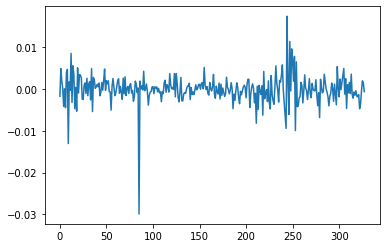

n=800时,328天的日均超额收益:-0.0001 	 年化超额收益:-0.0218


In [53]:
policy2 = get_policy2(800,y_pred,y_true,m_score)
policy2 = struct(policy2,y_true)
ex_ret2 = excess_return(policy2,idxc_weight,y_true)
ex_ret_mean2,ex_ret_annul2 = ex_ret_mean_annul(ex_ret2)
plt.plot(ex_ret2)
plt.show()
print("n=%d时,%d天的日均超额收益:%.4f \t 年化超额收益:%.4f" % (800,len(ex_ret2),ex_ret_mean2,ex_ret_annul2))

In [54]:
var_score = rolling_var(y_true,window=10)

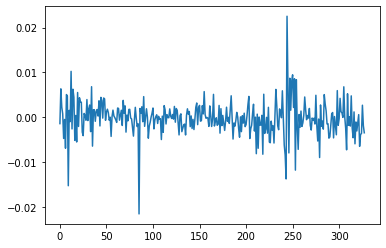

n=800时,328天的日均超额收益:-0.0003 	 年化超额收益:-0.0653


In [57]:
policy3 = get_policy3(800,y_pred,y_true,var_score)
policy3 = struct(policy3,y_true)
ex_ret3 = excess_return(policy3,idxc_weight,y_true)
ex_ret_mean3,ex_ret_annul3 = ex_ret_mean_annul(ex_ret3)
plt.plot(ex_ret3)
plt.show()
print("n=%d时,%d天的日均超额收益:%.4f \t 年化超额收益:%.4f" % (800,len(ex_ret3),ex_ret_mean3,ex_ret_annul3))